In [1]:
import torch
import scanpy as sc

from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import os
from sklearn.decomposition import PCA
from scvi.model import SCVI
from scripts import constants
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Global seed set to 0


In [2]:
dataset = "haber_2017"

In [3]:
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes.h5ad",
    )
)

target_adata = adata[adata.obs["condition"] != "Control"].copy()
background_adata = adata[adata.obs["condition"] == "Control"].copy()

target_trans_adata = target_adata.copy()
background_trans_adata = background_adata.copy()

SCVI.setup_anndata(target_adata, layer="count")
SCVI.setup_anndata(target_trans_adata)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Successfully registered anndata object containing 4481 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 4

# Evaluating Salient Representations

In [4]:
seeds = constants.DEFAULT_SEEDS
latent_size=10

In [5]:
salient_representation_dict = {}
salient_representation_dict["contrastiveVI"] = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]
salient_representation_dict["cVAE"] = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/cVAE_tc/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 784.16it/s]


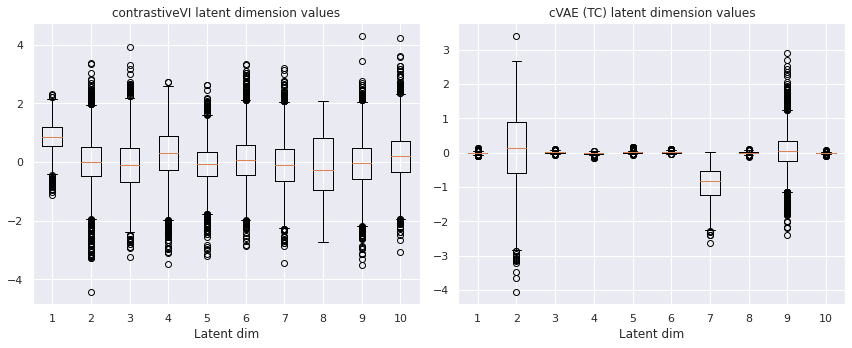

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].boxplot(salient_representation_dict["contrastiveVI"][0])
axs[0].set_title("contrastiveVI latent dimension values")
axs[0].set_xlabel("Latent dim")

axs[1].boxplot(salient_representation_dict["cVAE"][0])
axs[1].set_title("cVAE (TC) latent dimension values")
axs[1].set_xlabel("Latent dim")

plt.tight_layout()
plt.show()

In [7]:
from scipy.stats import sem

models = ["contrastiveVI", "cVAE"]
labels = target_adata.obs["condition"]
one_hot_labels = LabelEncoder().fit_transform(labels)

silhouette_results_dict = {}
ari_results_dict = {}
nmi_results_dict = {}

for model_name, latent_list in salient_representation_dict.items():
    print(f"Evaluating {model_name} representations...")
    silhouette_results = []
    ari_results = []
    nmi_results = []
    
    for latent in tqdm(latent_list):
        latent_clustering = KMeans(2, random_state=123).fit_predict(latent)
        silhouette_results.append(silhouette_score(latent, one_hot_labels))
        ari_results.append(adjusted_rand_score(one_hot_labels, latent_clustering))
        nmi_results.append(adjusted_mutual_info_score(one_hot_labels, latent_clustering))
        
    silhouette_results_dict[model_name] = silhouette_results
    ari_results_dict[model_name] = ari_results
    nmi_results_dict[model_name] = nmi_results

Evaluating contrastiveVI representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]


Evaluating cVAE representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.13s/it]


Text(0.5, 1.0, 'Cell Type Clustering Performance (Background)')

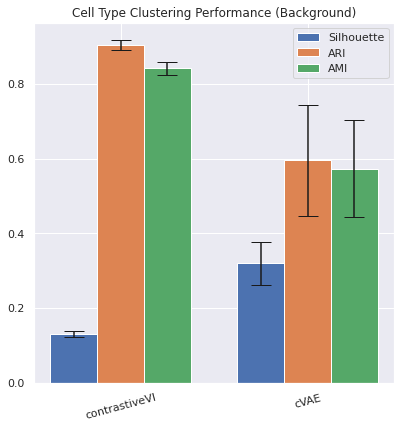

In [9]:
from scipy.stats import sem

model_labels = [model_name for model_name in salient_representation_dict.keys()]
width = 0.25  # Bar width
x = np.arange(len(model_labels))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(
    x,
    [np.mean(silhouette_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(silhouette_results_dict[model_label]) for model_label in model_labels],
    capsize=10,
    label="Silhouette",
)
ax.bar(
    x + width,
    [np.mean(ari_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(ari_results_dict[model_label]) for model_label in model_labels],
    capsize=10,
    label="ARI",
)
ax.bar(
    x + width * 2,
    [np.mean(nmi_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(nmi_results_dict[model_label]) for model_label in model_labels],
    capsize=10,
    label="AMI",
)

ax.set_xticks(x + width)
ax.set_xticklabels(model_labels, rotation=15)
ax.legend()
ax.set_title("Cell Type Clustering Performance (Background)")

# Evaluating Background Representations

In [10]:
device = 'cuda:1'

contrastiveVI_models = [torch.load(
    os.path.join(constants.DEFAULT_RESULTS_PATH, f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}/model.ckpt"),
    map_location=device,
) for seed in constants.DEFAULT_SEEDS]

cVAE_tc_models = [torch.load(
    os.path.join(constants.DEFAULT_RESULTS_PATH, f"{dataset}/cVAE_tc/latent_{latent_size}/{seed}/model.ckpt"),
    map_location=device
) for seed in constants.DEFAULT_SEEDS]

background_representation_dict = {}
background_representation_dict["contrastiveVI"] = [model.get_latent_representation(target_adata, representation_kind="background") for model in contrastiveVI_models]
background_representation_dict["cVAE"] = [cVAE_tc_model.get_latent_representation(target_adata, representation_kind="background") for cVAE_tc_model in cVAE_tc_models]

During startup - Warning messages:
1: package ‘methods’ was built under R version 3.6.1 
2: package ‘datasets’ was built under R version 3.6.1 
3: package ‘utils’ was built under R version 3.6.1 
4: package ‘grDevices’ was built under R version 3.6.1 
5: package ‘graphics’ was built under R version 3.6.1 
6: package ‘stats’ was built under R version 3.6.1 


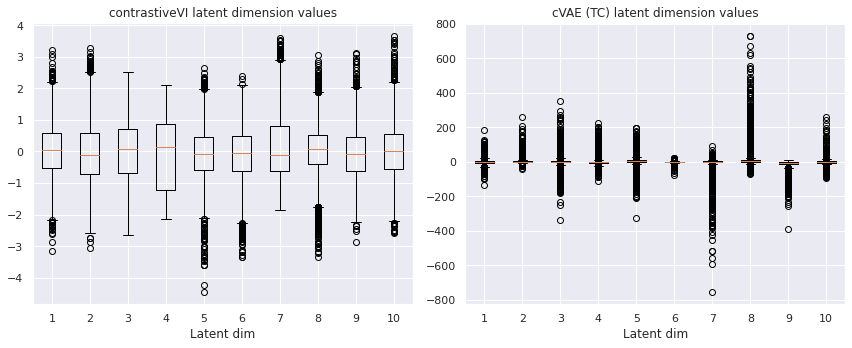

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].boxplot(background_representation_dict["contrastiveVI"][0])
axs[0].set_title("contrastiveVI latent dimension values")
axs[0].set_xlabel("Latent dim")

axs[1].boxplot(background_representation_dict["cVAE"][0])
axs[1].set_title("cVAE (TC) latent dimension values")
axs[1].set_xlabel("Latent dim")

plt.tight_layout()
plt.show()

In [12]:
from scipy.stats import sem

models = ["contrastiveVI", "cVAE"]
labels = target_adata.obs["cell_type"]
one_hot_labels = LabelEncoder().fit_transform(labels)

silhouette_results_dict = {}
ari_results_dict = {}
nmi_results_dict = {}

for model_name, latent_list in background_representation_dict.items():
    print(f"Evaluating {model_name} representations...")
    silhouette_results = []
    ari_results = []
    nmi_results = []
    
    for latent in tqdm(latent_list):
        latent_clustering = KMeans(len(labels.unique()), random_state=123).fit_predict(latent)
        silhouette_results.append(silhouette_score(latent, one_hot_labels))
        ari_results.append(adjusted_rand_score(one_hot_labels, latent_clustering))
        nmi_results.append(adjusted_mutual_info_score(one_hot_labels, latent_clustering))
        
    silhouette_results_dict[model_name] = silhouette_results
    ari_results_dict[model_name] = ari_results
    nmi_results_dict[model_name] = nmi_results

Evaluating contrastiveVI representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]


Evaluating cVAE representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/it]


Text(0.5, 1.0, 'Cell Type Clustering Performance (Background)')

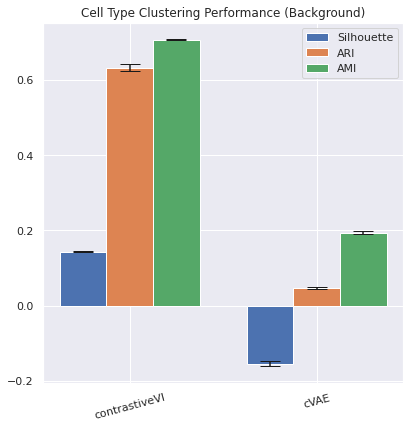

In [13]:
from scipy.stats import sem

model_labels = [model_name for model_name in background_representation_dict.keys()]
width = 0.25  # Bar width
x = np.arange(len(model_labels))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(
    x,
    [np.mean(silhouette_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(silhouette_results_dict[model_label]) for model_label in model_labels],
    capsize=10,
    label="Silhouette",
)
ax.bar(
    x + width,
    [np.mean(ari_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(ari_results_dict[model_label]) for model_label in model_labels],
    capsize=10,
    label="ARI",
)
ax.bar(
    x + width * 2,
    [np.mean(nmi_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(nmi_results_dict[model_label]) for model_label in model_labels],
    capsize=10,
    label="AMI",
)

ax.set_xticks(x + width)
ax.set_xticklabels(model_labels, rotation=15)
ax.legend()
ax.set_title("Cell Type Clustering Performance (Background)")

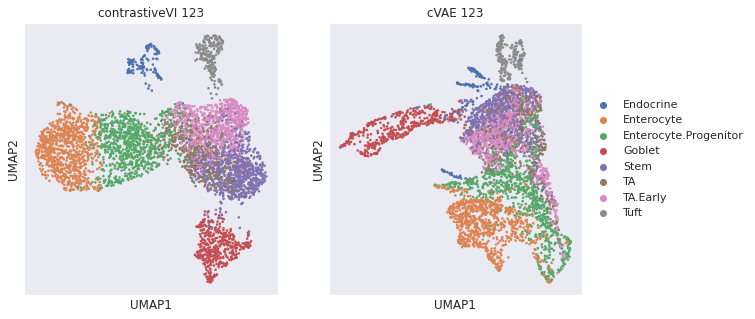

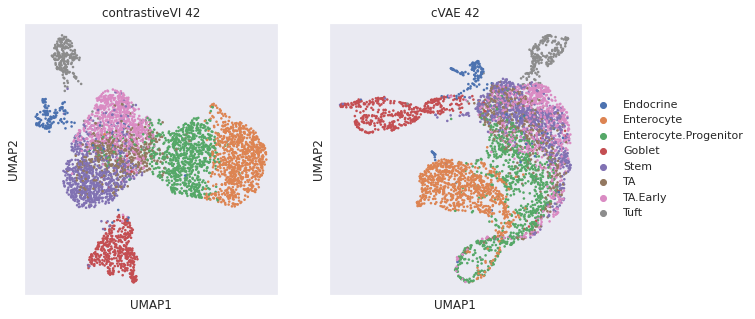

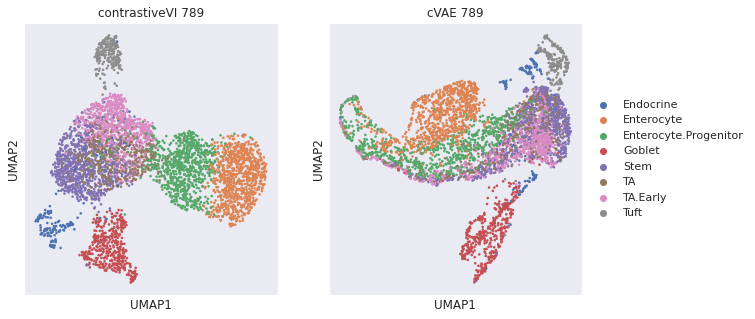

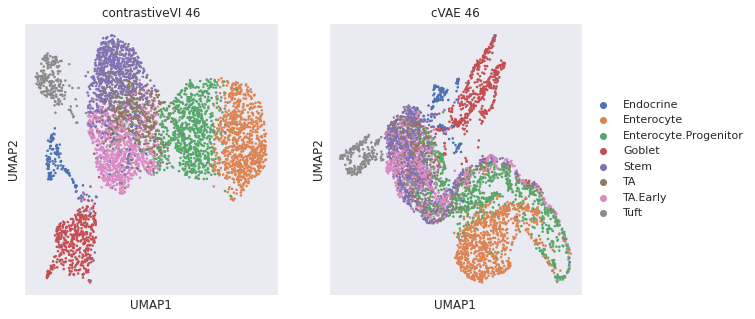

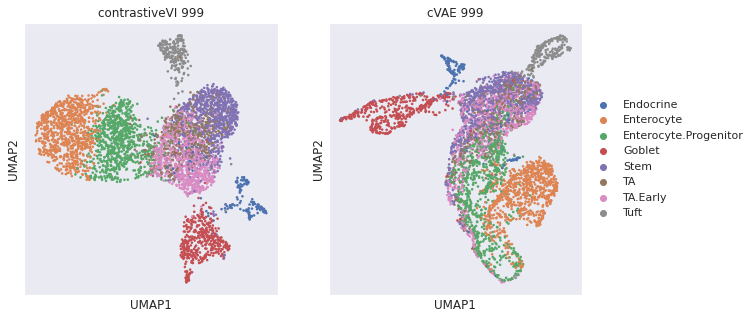

In [14]:
from anndata import AnnData
import scanpy as sc

for i, seed in enumerate(seeds):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    adata_contrastive_vi = AnnData(X=background_representation_dict["contrastiveVI"][i], obs=target_adata.obs)
    sc.pp.neighbors(adata_contrastive_vi)
    sc.tl.umap(adata_contrastive_vi)
    sc.pl.umap(adata_contrastive_vi, color='cell_type', ax=ax1, show=False, legend_loc=None, title=f"contrastiveVI (seed={seed})")

    adata_cvae = AnnData(X=background_representation_dict["cVAE"][i], obs=target_adata.obs)
    sc.pp.neighbors(adata_cvae)
    sc.tl.umap(adata_cvae)
    sc.pl.umap(adata_cvae, color='cell_type', ax=ax2, title=f"cVAE (seed={seed})")

    plt.show()